# GAN Classifier
### Imports:

In [1]:
from IPython.display import Image, SVG
%matplotlib inline

import time
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


***
### HYPERPARAMETERS & OPTIONS

In [2]:
### DATA SELECTION ###
bkg_filename = "../background_Full_Test3.txt"
sig_filename = "../signal_Full_Test3.txt"
drop_PHI_columns = False
n_train = 25000
scaler = MinMaxScaler()

### OPTIONS ###
savePlots = True
plotsLocation = "./"

### GAN ###
n_epochs = 2500
batch_size = 265
loadNetworks = False

    # Discriminator
loadWeightsD = False

    ## Generator
noise_dim = 7
loadWeightsG  = False

***
### Load data & Preprocessing

In [3]:
bkg_all = pd.read_csv(bkg_filename, delimiter=' ', index_col=False)
sig_all = pd.read_csv(sig_filename, delimiter=' ', index_col=False)

def coordinate_change (df):
    pt1 = np.sqrt(df['px1']**2 + df['py1']**2)
    theta1 = np.arctan2(pt1,df['pz1'])
    eta1 = -1 * np.log(np.tan(theta1/2))
    phi1 = np.arctan2(df['py1'],df['px1'])
    pt2 = np.sqrt(df['px2']**2 + df['py2']**2)
    theta2 = np.arctan2(pt2,df['pz2'])
    eta2 = -1 * np.log(np.tan(theta2/2))
    phi2 = np.arctan2(df['py2'],df['px2'])
    df['px1'] = pt1
    df['py1'] = eta1
    df['pz1'] = phi1
    df['px2'] = pt2
    df['py2'] = eta2
    df['pz2'] = phi2
    df.rename(columns={'px1':'$p_{t1}$', 'py1':'$\eta_{1}$', 'pz1':'$\phi_{1}$', 'px2':'$p_{t2}$',
                       'py2':'$\eta_{2}$', 'pz2':'$\phi_{2}$', 'E1':'$E_1$', 'E2':'$E_2$', 'M1':'$M_1$',
                       'M2':'$M_2$', 'M12':'$M_{1 2}$'}, inplace=True)
    
coordinate_change(sig_all)
coordinate_change(bkg_all)

if drop_PHI_columns:
    sig_sel = sig_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
    bkg_sel = bkg_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
else:
    sig_sel = sig_all
    bkg_sel = bkg_all
    
data_header = list(sig_sel)

sig_shuffled = shuffle(sig_sel)
bkg_shuffled = shuffle(bkg_sel)

n_bkg = len(bkg_sel.iloc[:,:0])
n_sig = len(sig_sel.iloc[:,:0])
f_s = n_train/n_sig
f_b = n_train/n_bkg

print ("Number of BACKGROUND events:", n_bkg)
print ("%0.2f%% = %d" % (f_b*100, n_train), "used for TRAINING")
print ("%.2f%% = %d" % (f_b*100, n_train), "used for TESTING")
print ("%05.2f%% = %d" % ((1-2*f_b)*100, n_bkg - 2*n_train), "unused")
print ("Number of SIGNAL events:", n_sig)
print ("%.2f%% = %d" % (f_s*100, n_train), "used for TESTING")
print ("%.2f%% = %d" % ((1-f_s)*100, n_sig - n_train), "unused")
print ("\n")

sample_train = bkg_sel[:n_train]
sample_test = pd.concat([bkg_sel.iloc[n_train:2*n_train], sig_sel.iloc[:n_train]])
sample_test = sample_test.reset_index(drop=True)

input_dim = sample_train.shape[1]

sample_train = scaler.fit_transform(sample_train)
sample_test = scaler.transform(sample_test)

print('Training sample size: ',sample_train.shape)
print('Testing sample size: ',sample_test.shape)

sample_train_input, sample_train_valid = train_test_split(sample_train,test_size=0.2,random_state=13) 
train_time = 0
n_cycle = 0

Number of BACKGROUND events: 54194
46.13% = 25000 used for TRAINING
46.13% = 25000 used for TESTING
07.74% = 4194 unused
Number of SIGNAL events: 52766
47.38% = 25000 used for TESTING
52.62% = 27766 unused


Training sample size:  (25000, 13)
Testing sample size:  (50000, 13)


***
### Discriminator Model

In [4]:
if not(loadNetworks):
    discriminator = Sequential()
    discriminator.add(Dense(20, input_shape=(input_dim,), activation='relu', name='discriminator_hidden_1'))
    discriminator.add(Dense(20, activation='relu', name='discriminator_hidden_2'))
    discriminator.add(Dense(10, activation='relu', name='discriminator_hidden_3'))
    discriminator.add(Dense(5, activation='relu', name='discriminator_hidden_4'))
    discriminator.add(Dense(2, activation='sigmoid', name='discriminator_output'))

if loadWeightsD:
    discriminator.load_weights("discriminator.h5")
    
discriminator.summary()
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_hidden_1 (Dens (None, 20)                280       
_________________________________________________________________
discriminator_hidden_2 (Dens (None, 20)                420       
_________________________________________________________________
discriminator_hidden_3 (Dens (None, 10)                210       
_________________________________________________________________
discriminator_hidden_4 (Dens (None, 5)                 55        
_________________________________________________________________
discriminator_output (Dense) (None, 2)                 12        
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


### Generator 

In [5]:
if not(loadNetworks):
    generator = Sequential()
    generator.add(Dense(10, input_shape=(noise_dim,), activation='relu', name='generator_hidden_1'))
    generator.add(Dense(20 , activation='relu', name='generator_hidden_2'))
    generator.add(Dense(15, activation='relu', name='generator_hidden_3'))
    generator.add(Dense(input_dim, activation='sigmoid', name='generator_output'))

    
if loadWeightsG:
    generator.load_weights("generator.h5")    

generator.summary()
generator.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_hidden_1 (Dense)   (None, 10)                80        
_________________________________________________________________
generator_hidden_2 (Dense)   (None, 20)                220       
_________________________________________________________________
generator_hidden_3 (Dense)   (None, 15)                315       
_________________________________________________________________
generator_output (Dense)     (None, 13)                208       
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


### Adversarial Model

In [6]:
input_img_adv = Input(shape=(noise_dim,))
AM = Sequential()
output_img_gen = generator.layers[3](generator.layers[2](generator.layers[1](generator.layers[0](input_img_adv))))
output_img_adv = discriminator.layers[4](discriminator.layers[3](discriminator.layers[2](discriminator.layers[1](discriminator.layers[0](output_img_gen)))))

AM = Model(input_img_adv, output_img_adv)

AM.get_layer('discriminator_hidden_1').trainable = False
AM.get_layer('discriminator_hidden_2').trainable = False
AM.get_layer('discriminator_hidden_3').trainable = False
AM.get_layer('discriminator_hidden_4').trainable = False
AM.get_layer('discriminator_output').trainable = False

AM.compile(loss='binary_crossentropy', optimizer='adam')

AM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
generator_hidden_1 (Dense)   (None, 10)                80        
_________________________________________________________________
generator_hidden_2 (Dense)   (None, 20)                220       
_________________________________________________________________
generator_hidden_3 (Dense)   (None, 15)                315       
_________________________________________________________________
generator_output (Dense)     (None, 13)                208       
_________________________________________________________________
discriminator_hidden_1 (Dens (None, 20)                280       
_________________________________________________________________
discriminator_hidden_2 (Dens (None, 20)                420       
__________

### Training

In [7]:
train_steps = n_epochs
discriminator_history = []
adversarial_history = []

start = time.time()

with tf.device('/GPU:0'):
    for i in range(train_steps):
            data_train = sample_train[np.random.randint(0,sample_train.shape[0], size=batch_size)]
            noise = np.random.uniform(0, 1.0, size=[batch_size, noise_dim])
            data_fake = generator.predict(noise)
            x = np.concatenate((data_train, data_fake))
            y = np.concatenate((np.tile([0,1], [batch_size,1]), (np.tile([1,0], [batch_size,1]))))
            d_loss = discriminator.train_on_batch(x, y)
            discriminator_history.append(d_loss)
            noise = np.random.uniform(0, 1.0, size=[batch_size, noise_dim])
            y = np.tile([0,1], [batch_size,1])
            a_loss = AM.train_on_batch(noise, y)
            adversarial_history.append(a_loss)
            prc = ((i+1)/train_steps)*100
            log_mesg = "%.2f%%  %d [D loss: %f]" % (prc, i, d_loss)
            log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
            print(log_mesg)
            
end = time.time()
train_time += (end-start)
n_cycle += 1

/home/ioan/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0.04%  0 [D loss: 0.691088]  [A loss: 0.691728]
0.08%  1 [D loss: 0.689907]  [A loss: 0.692968]
0.12%  2 [D loss: 0.688803]  [A loss: 0.693392]
0.16%  3 [D loss: 0.688526]  [A loss: 0.693732]
0.20%  4 [D loss: 0.688365]  [A loss: 0.694107]
0.24%  5 [D loss: 0.687669]  [A loss: 0.694454]
0.28%  6 [D loss: 0.687732]  [A loss: 0.694678]
0.32%  7 [D loss: 0.686425]  [A loss: 0.694900]
0.36%  8 [D loss: 0.686120]  [A loss: 0.695121]
0.40%  9 [D loss: 0.686299]  [A loss: 0.695717]
0.44%  10 [D loss: 0.685162]  [A loss: 0.696268]
0.48%  11 [D loss: 0.685033]  [A loss: 0.696848]
0.52%  12 [D loss: 0.684090]  [A loss: 0.697507]
0.56%  13 [D loss: 0.683374]  [A loss: 0.698077]
0.60%  14 [D loss: 0.682481]  [A loss: 0.698641]
0.64%  15 [D loss: 0.681699]  [A loss: 0.699049]
0.68%  16 [D loss: 0.681167]  [A loss: 0.699592]
0.72%  17 [D loss: 0.680830]  [A loss: 0.699817]
0.76%  18 [D loss: 0.679860]  [A loss: 0.700179]
0.80%  19 [D loss: 0.678726]  [A loss: 0.700598]
0.84%  20 [D loss: 0.678943]  

6.84%  170 [D loss: 0.419844]  [A loss: 0.821642]
6.88%  171 [D loss: 0.416220]  [A loss: 0.820716]
6.92%  172 [D loss: 0.413762]  [A loss: 0.817085]
6.96%  173 [D loss: 0.422209]  [A loss: 0.825194]
7.00%  174 [D loss: 0.419932]  [A loss: 0.819860]
7.04%  175 [D loss: 0.418774]  [A loss: 0.819666]
7.08%  176 [D loss: 0.413702]  [A loss: 0.824116]
7.12%  177 [D loss: 0.419950]  [A loss: 0.822840]
7.16%  178 [D loss: 0.418361]  [A loss: 0.821709]
7.20%  179 [D loss: 0.416942]  [A loss: 0.827101]
7.24%  180 [D loss: 0.434345]  [A loss: 0.825540]
7.28%  181 [D loss: 0.424007]  [A loss: 0.826847]
7.32%  182 [D loss: 0.434071]  [A loss: 0.830605]
7.36%  183 [D loss: 0.426646]  [A loss: 0.829914]
7.40%  184 [D loss: 0.432925]  [A loss: 0.827548]
7.44%  185 [D loss: 0.445591]  [A loss: 0.824087]
7.48%  186 [D loss: 0.448586]  [A loss: 0.827553]
7.52%  187 [D loss: 0.466664]  [A loss: 0.829110]
7.56%  188 [D loss: 0.469722]  [A loss: 0.822605]
7.60%  189 [D loss: 0.460288]  [A loss: 0.816485]


13.52%  337 [D loss: 0.705349]  [A loss: 0.893091]
13.56%  338 [D loss: 0.706134]  [A loss: 0.893030]
13.60%  339 [D loss: 0.706163]  [A loss: 0.889599]
13.64%  340 [D loss: 0.705683]  [A loss: 0.891676]
13.68%  341 [D loss: 0.705001]  [A loss: 0.890009]
13.72%  342 [D loss: 0.704733]  [A loss: 0.890897]
13.76%  343 [D loss: 0.703215]  [A loss: 0.890343]
13.80%  344 [D loss: 0.702923]  [A loss: 0.889507]
13.84%  345 [D loss: 0.705013]  [A loss: 0.888274]
13.88%  346 [D loss: 0.703708]  [A loss: 0.887510]
13.92%  347 [D loss: 0.704704]  [A loss: 0.885701]
13.96%  348 [D loss: 0.700220]  [A loss: 0.887572]
14.00%  349 [D loss: 0.702392]  [A loss: 0.886211]
14.04%  350 [D loss: 0.703113]  [A loss: 0.885302]
14.08%  351 [D loss: 0.701762]  [A loss: 0.883873]
14.12%  352 [D loss: 0.700049]  [A loss: 0.882424]
14.16%  353 [D loss: 0.703058]  [A loss: 0.880313]
14.20%  354 [D loss: 0.700512]  [A loss: 0.880136]
14.24%  355 [D loss: 0.700376]  [A loss: 0.880155]
14.28%  356 [D loss: 0.701519] 

19.96%  498 [D loss: 0.379615]  [A loss: 0.853386]
20.00%  499 [D loss: 0.379137]  [A loss: 0.849036]
20.04%  500 [D loss: 0.383130]  [A loss: 0.856897]
20.08%  501 [D loss: 0.373488]  [A loss: 0.859539]
20.12%  502 [D loss: 0.371213]  [A loss: 0.865456]
20.16%  503 [D loss: 0.365865]  [A loss: 0.864472]
20.20%  504 [D loss: 0.365144]  [A loss: 0.867409]
20.24%  505 [D loss: 0.365172]  [A loss: 0.866019]
20.28%  506 [D loss: 0.360854]  [A loss: 0.868006]
20.32%  507 [D loss: 0.371977]  [A loss: 0.860070]
20.36%  508 [D loss: 0.364485]  [A loss: 0.863662]
20.40%  509 [D loss: 0.359232]  [A loss: 0.871577]
20.44%  510 [D loss: 0.361083]  [A loss: 0.873836]
20.48%  511 [D loss: 0.355501]  [A loss: 0.875437]
20.52%  512 [D loss: 0.358931]  [A loss: 0.874296]
20.56%  513 [D loss: 0.347665]  [A loss: 0.874702]
20.60%  514 [D loss: 0.351993]  [A loss: 0.870987]
20.64%  515 [D loss: 0.348985]  [A loss: 0.871804]
20.68%  516 [D loss: 0.351550]  [A loss: 0.875683]
20.72%  517 [D loss: 0.353962] 

26.64%  665 [D loss: 0.236168]  [A loss: 1.012120]
26.68%  666 [D loss: 0.234868]  [A loss: 1.013160]
26.72%  667 [D loss: 0.235842]  [A loss: 1.014276]
26.76%  668 [D loss: 0.232966]  [A loss: 1.015331]
26.80%  669 [D loss: 0.234497]  [A loss: 1.016436]
26.84%  670 [D loss: 0.230583]  [A loss: 1.017180]
26.88%  671 [D loss: 0.232211]  [A loss: 1.018600]
26.92%  672 [D loss: 0.228786]  [A loss: 1.019683]
26.96%  673 [D loss: 0.229556]  [A loss: 1.020767]
27.00%  674 [D loss: 0.227853]  [A loss: 1.021852]
27.04%  675 [D loss: 0.229158]  [A loss: 1.022787]
27.08%  676 [D loss: 0.227922]  [A loss: 1.023288]
27.12%  677 [D loss: 0.228886]  [A loss: 1.025077]
27.16%  678 [D loss: 0.224799]  [A loss: 1.024996]
27.20%  679 [D loss: 0.228621]  [A loss: 1.027121]
27.24%  680 [D loss: 0.231022]  [A loss: 1.025714]
27.28%  681 [D loss: 0.224348]  [A loss: 1.026325]
27.32%  682 [D loss: 0.225020]  [A loss: 1.028167]
27.36%  683 [D loss: 0.224924]  [A loss: 1.027403]
27.40%  684 [D loss: 0.223317] 

33.96%  848 [D loss: 0.518927]  [A loss: 1.070967]
34.00%  849 [D loss: 0.531330]  [A loss: 1.043707]
34.04%  850 [D loss: 0.539487]  [A loss: 1.035599]
34.08%  851 [D loss: 0.553126]  [A loss: 1.080723]
34.12%  852 [D loss: 0.548373]  [A loss: 1.109740]
34.16%  853 [D loss: 0.515205]  [A loss: 1.134192]
34.20%  854 [D loss: 0.504320]  [A loss: 1.140794]
34.24%  855 [D loss: 0.501488]  [A loss: 1.143057]
34.28%  856 [D loss: 0.496876]  [A loss: 1.142965]
34.32%  857 [D loss: 0.566758]  [A loss: 1.142418]
34.36%  858 [D loss: 0.512120]  [A loss: 1.142316]
34.40%  859 [D loss: 0.513983]  [A loss: 1.142553]
34.44%  860 [D loss: 0.532739]  [A loss: 1.142389]
34.48%  861 [D loss: 0.547637]  [A loss: 1.142205]
34.52%  862 [D loss: 0.514529]  [A loss: 1.142014]
34.56%  863 [D loss: 0.514883]  [A loss: 1.141818]
34.60%  864 [D loss: 0.537472]  [A loss: 1.141608]
34.64%  865 [D loss: 0.496971]  [A loss: 1.141335]
34.68%  866 [D loss: 0.495447]  [A loss: 1.140660]
34.72%  867 [D loss: 0.534068] 

41.12%  1027 [D loss: 0.466721]  [A loss: 1.078607]
41.16%  1028 [D loss: 0.437203]  [A loss: 1.082541]
41.20%  1029 [D loss: 0.450481]  [A loss: 1.096914]
41.24%  1030 [D loss: 0.489030]  [A loss: 1.095532]
41.28%  1031 [D loss: 0.479725]  [A loss: 1.083940]
41.32%  1032 [D loss: 0.464624]  [A loss: 1.056723]
41.36%  1033 [D loss: 0.472725]  [A loss: 1.077783]
41.40%  1034 [D loss: 0.498354]  [A loss: 1.061717]
41.44%  1035 [D loss: 0.510291]  [A loss: 1.061758]
41.48%  1036 [D loss: 0.496899]  [A loss: 1.077634]
41.52%  1037 [D loss: 0.521152]  [A loss: 1.059496]
41.56%  1038 [D loss: 0.492909]  [A loss: 1.088444]
41.60%  1039 [D loss: 0.542771]  [A loss: 1.024987]
41.64%  1040 [D loss: 0.570092]  [A loss: 1.060072]
41.68%  1041 [D loss: 0.523815]  [A loss: 1.047620]
41.72%  1042 [D loss: 0.553254]  [A loss: 1.031488]
41.76%  1043 [D loss: 0.584344]  [A loss: 1.001076]
41.80%  1044 [D loss: 0.625425]  [A loss: 0.981749]
41.84%  1045 [D loss: 0.653550]  [A loss: 0.991147]
41.88%  1046

48.52%  1212 [D loss: 0.728733]  [A loss: 0.996324]
48.56%  1213 [D loss: 0.728573]  [A loss: 0.995553]
48.60%  1214 [D loss: 0.728413]  [A loss: 0.994784]
48.64%  1215 [D loss: 0.728254]  [A loss: 0.994018]
48.68%  1216 [D loss: 0.728096]  [A loss: 0.993254]
48.72%  1217 [D loss: 0.727939]  [A loss: 0.992492]
48.76%  1218 [D loss: 0.727782]  [A loss: 0.991732]
48.80%  1219 [D loss: 0.727626]  [A loss: 0.990975]
48.84%  1220 [D loss: 0.727471]  [A loss: 0.990219]
48.88%  1221 [D loss: 0.727316]  [A loss: 0.989466]
48.92%  1222 [D loss: 0.727162]  [A loss: 0.988715]
48.96%  1223 [D loss: 0.727009]  [A loss: 0.987967]
49.00%  1224 [D loss: 0.726857]  [A loss: 0.987220]
49.04%  1225 [D loss: 0.726705]  [A loss: 0.986476]
49.08%  1226 [D loss: 0.726554]  [A loss: 0.985733]
49.12%  1227 [D loss: 0.726404]  [A loss: 0.984993]
49.16%  1228 [D loss: 0.726254]  [A loss: 0.984255]
49.20%  1229 [D loss: 0.726105]  [A loss: 0.983519]
49.24%  1230 [D loss: 0.725957]  [A loss: 0.982785]
49.28%  1231

55.20%  1379 [D loss: 0.709845]  [A loss: 0.892585]
55.24%  1380 [D loss: 0.709768]  [A loss: 0.892086]
55.28%  1381 [D loss: 0.709692]  [A loss: 0.891589]
55.32%  1382 [D loss: 0.709616]  [A loss: 0.891092]
55.36%  1383 [D loss: 0.709540]  [A loss: 0.890597]
55.40%  1384 [D loss: 0.709465]  [A loss: 0.890103]
55.44%  1385 [D loss: 0.709390]  [A loss: 0.889610]
55.48%  1386 [D loss: 0.709315]  [A loss: 0.889118]
55.52%  1387 [D loss: 0.709241]  [A loss: 0.888627]
55.56%  1388 [D loss: 0.709167]  [A loss: 0.888138]
55.60%  1389 [D loss: 0.709093]  [A loss: 0.887650]
55.64%  1390 [D loss: 0.709020]  [A loss: 0.887163]
55.68%  1391 [D loss: 0.708947]  [A loss: 0.886677]
55.72%  1392 [D loss: 0.708874]  [A loss: 0.886192]
55.76%  1393 [D loss: 0.708802]  [A loss: 0.885708]
55.80%  1394 [D loss: 0.708730]  [A loss: 0.885226]
55.84%  1395 [D loss: 0.708658]  [A loss: 0.884744]
55.88%  1396 [D loss: 0.708586]  [A loss: 0.884264]
55.92%  1397 [D loss: 0.708515]  [A loss: 0.883785]
55.96%  1398

61.76%  1543 [D loss: 0.700825]  [A loss: 0.824535]
61.80%  1544 [D loss: 0.700787]  [A loss: 0.824194]
61.84%  1545 [D loss: 0.700750]  [A loss: 0.823853]
61.88%  1546 [D loss: 0.700713]  [A loss: 0.823514]
61.92%  1547 [D loss: 0.700676]  [A loss: 0.823175]
61.96%  1548 [D loss: 0.700639]  [A loss: 0.822836]
62.00%  1549 [D loss: 0.700602]  [A loss: 0.822499]
62.04%  1550 [D loss: 0.700566]  [A loss: 0.822162]
62.08%  1551 [D loss: 0.700529]  [A loss: 0.821827]
62.12%  1552 [D loss: 0.700493]  [A loss: 0.821491]
62.16%  1553 [D loss: 0.700457]  [A loss: 0.821157]
62.20%  1554 [D loss: 0.700421]  [A loss: 0.820824]
62.24%  1555 [D loss: 0.700385]  [A loss: 0.820491]
62.28%  1556 [D loss: 0.700350]  [A loss: 0.820159]
62.32%  1557 [D loss: 0.700314]  [A loss: 0.819827]
62.36%  1558 [D loss: 0.700279]  [A loss: 0.819497]
62.40%  1559 [D loss: 0.700244]  [A loss: 0.819167]
62.44%  1560 [D loss: 0.700209]  [A loss: 0.818838]
62.48%  1561 [D loss: 0.700174]  [A loss: 0.818510]
62.52%  1562

68.52%  1712 [D loss: 0.696386]  [A loss: 0.776646]
68.56%  1713 [D loss: 0.696368]  [A loss: 0.776415]
68.60%  1714 [D loss: 0.696351]  [A loss: 0.776184]
68.64%  1715 [D loss: 0.696334]  [A loss: 0.775953]
68.68%  1716 [D loss: 0.696317]  [A loss: 0.775724]
68.72%  1717 [D loss: 0.696300]  [A loss: 0.775495]
68.76%  1718 [D loss: 0.696284]  [A loss: 0.775266]
68.80%  1719 [D loss: 0.696267]  [A loss: 0.775038]
68.84%  1720 [D loss: 0.696250]  [A loss: 0.774810]
68.88%  1721 [D loss: 0.696234]  [A loss: 0.774583]
68.92%  1722 [D loss: 0.696217]  [A loss: 0.774356]
68.96%  1723 [D loss: 0.696201]  [A loss: 0.774130]
69.00%  1724 [D loss: 0.696184]  [A loss: 0.773905]
69.04%  1725 [D loss: 0.696168]  [A loss: 0.773680]
69.08%  1726 [D loss: 0.696152]  [A loss: 0.773455]
69.12%  1727 [D loss: 0.696136]  [A loss: 0.773232]
69.16%  1728 [D loss: 0.696120]  [A loss: 0.773008]
69.20%  1729 [D loss: 0.696104]  [A loss: 0.772785]
69.24%  1730 [D loss: 0.696088]  [A loss: 0.772563]
69.28%  1731

75.44%  1885 [D loss: 0.694378]  [A loss: 0.743817]
75.48%  1886 [D loss: 0.694371]  [A loss: 0.743665]
75.52%  1887 [D loss: 0.694364]  [A loss: 0.743513]
75.56%  1888 [D loss: 0.694357]  [A loss: 0.743361]
75.60%  1889 [D loss: 0.694349]  [A loss: 0.743210]
75.64%  1890 [D loss: 0.694342]  [A loss: 0.743060]
75.68%  1891 [D loss: 0.694335]  [A loss: 0.742909]
75.72%  1892 [D loss: 0.694328]  [A loss: 0.742759]
75.76%  1893 [D loss: 0.694322]  [A loss: 0.742610]
75.80%  1894 [D loss: 0.694315]  [A loss: 0.742460]
75.84%  1895 [D loss: 0.694308]  [A loss: 0.742312]
75.88%  1896 [D loss: 0.694301]  [A loss: 0.742163]
75.92%  1897 [D loss: 0.694294]  [A loss: 0.742015]
75.96%  1898 [D loss: 0.694287]  [A loss: 0.741867]
76.00%  1899 [D loss: 0.694281]  [A loss: 0.741720]
76.04%  1900 [D loss: 0.694274]  [A loss: 0.741573]
76.08%  1901 [D loss: 0.694267]  [A loss: 0.741427]
76.12%  1902 [D loss: 0.694261]  [A loss: 0.741280]
76.16%  1903 [D loss: 0.694254]  [A loss: 0.741135]
76.20%  1904

82.04%  2050 [D loss: 0.693593]  [A loss: 0.723340]
82.08%  2051 [D loss: 0.693591]  [A loss: 0.723241]
82.12%  2052 [D loss: 0.693588]  [A loss: 0.723142]
82.16%  2053 [D loss: 0.693585]  [A loss: 0.723044]
82.20%  2054 [D loss: 0.693582]  [A loss: 0.722946]
82.24%  2055 [D loss: 0.693579]  [A loss: 0.722849]
82.28%  2056 [D loss: 0.693576]  [A loss: 0.722751]
82.32%  2057 [D loss: 0.693574]  [A loss: 0.722654]
82.36%  2058 [D loss: 0.693571]  [A loss: 0.722557]
82.40%  2059 [D loss: 0.693568]  [A loss: 0.722461]
82.44%  2060 [D loss: 0.693565]  [A loss: 0.722365]
82.48%  2061 [D loss: 0.693563]  [A loss: 0.722269]
82.52%  2062 [D loss: 0.693560]  [A loss: 0.722173]
82.56%  2063 [D loss: 0.693557]  [A loss: 0.722077]
82.60%  2064 [D loss: 0.693555]  [A loss: 0.721982]
82.64%  2065 [D loss: 0.693552]  [A loss: 0.721887]
82.68%  2066 [D loss: 0.693550]  [A loss: 0.721792]
82.72%  2067 [D loss: 0.693547]  [A loss: 0.721698]
82.76%  2068 [D loss: 0.693544]  [A loss: 0.721604]
82.80%  2069

88.68%  2216 [D loss: 0.693293]  [A loss: 0.710252]
88.72%  2217 [D loss: 0.693292]  [A loss: 0.710190]
88.76%  2218 [D loss: 0.693291]  [A loss: 0.710129]
88.80%  2219 [D loss: 0.693289]  [A loss: 0.710069]
88.84%  2220 [D loss: 0.693288]  [A loss: 0.710008]
88.88%  2221 [D loss: 0.693287]  [A loss: 0.709948]
88.92%  2222 [D loss: 0.693286]  [A loss: 0.709888]
88.96%  2223 [D loss: 0.693285]  [A loss: 0.709827]
89.00%  2224 [D loss: 0.693284]  [A loss: 0.709768]
89.04%  2225 [D loss: 0.693283]  [A loss: 0.709708]
89.08%  2226 [D loss: 0.693283]  [A loss: 0.709649]
89.12%  2227 [D loss: 0.693282]  [A loss: 0.709589]
89.16%  2228 [D loss: 0.693281]  [A loss: 0.709530]
89.20%  2229 [D loss: 0.693280]  [A loss: 0.709471]
89.24%  2230 [D loss: 0.693279]  [A loss: 0.709413]
89.28%  2231 [D loss: 0.693278]  [A loss: 0.709354]
89.32%  2232 [D loss: 0.693277]  [A loss: 0.709296]
89.36%  2233 [D loss: 0.693276]  [A loss: 0.709238]
89.40%  2234 [D loss: 0.693275]  [A loss: 0.709179]
89.44%  2235

95.20%  2379 [D loss: 0.693191]  [A loss: 0.702440]
95.24%  2380 [D loss: 0.693190]  [A loss: 0.702404]
95.28%  2381 [D loss: 0.693190]  [A loss: 0.702367]
95.32%  2382 [D loss: 0.693190]  [A loss: 0.702331]
95.36%  2383 [D loss: 0.693189]  [A loss: 0.702295]
95.40%  2384 [D loss: 0.693189]  [A loss: 0.702260]
95.44%  2385 [D loss: 0.693188]  [A loss: 0.702224]
95.48%  2386 [D loss: 0.693188]  [A loss: 0.702188]
95.52%  2387 [D loss: 0.693188]  [A loss: 0.702153]
95.56%  2388 [D loss: 0.693188]  [A loss: 0.702117]
95.60%  2389 [D loss: 0.693187]  [A loss: 0.702082]
95.64%  2390 [D loss: 0.693187]  [A loss: 0.702047]
95.68%  2391 [D loss: 0.693187]  [A loss: 0.702012]
95.72%  2392 [D loss: 0.693186]  [A loss: 0.701977]
95.76%  2393 [D loss: 0.693186]  [A loss: 0.701943]
95.80%  2394 [D loss: 0.693186]  [A loss: 0.701908]
95.84%  2395 [D loss: 0.693185]  [A loss: 0.701873]
95.88%  2396 [D loss: 0.693185]  [A loss: 0.701839]
95.92%  2397 [D loss: 0.693185]  [A loss: 0.701805]
95.96%  2398

### Training Loss

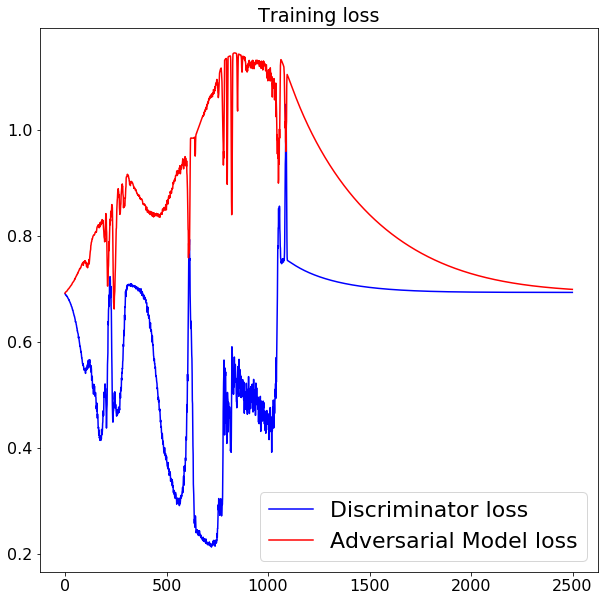

In [8]:
epochs = range(train_steps)
file_name = "%dcylce" % (n_cycle)
lossFig = plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plt.plot(epochs, discriminator_history, 'b', label='Discriminator loss')
plt.plot(epochs, adversarial_history, 'r', label='Adversarial Model loss')
plt.title('Training loss')
plt.legend(prop={'size': 22})
plt.show()

if savePlots:
    lossFig.savefig(plotsLocation + file_name + "Loss.png")

### Predictions

[[0.50307447 0.4973721 ]
 [0.50307447 0.4973721 ]
 [0.50307447 0.4973721 ]
 ...
 [0.50307447 0.4973721 ]
 [0.50307447 0.4973721 ]
 [0.50307447 0.4973721 ]]


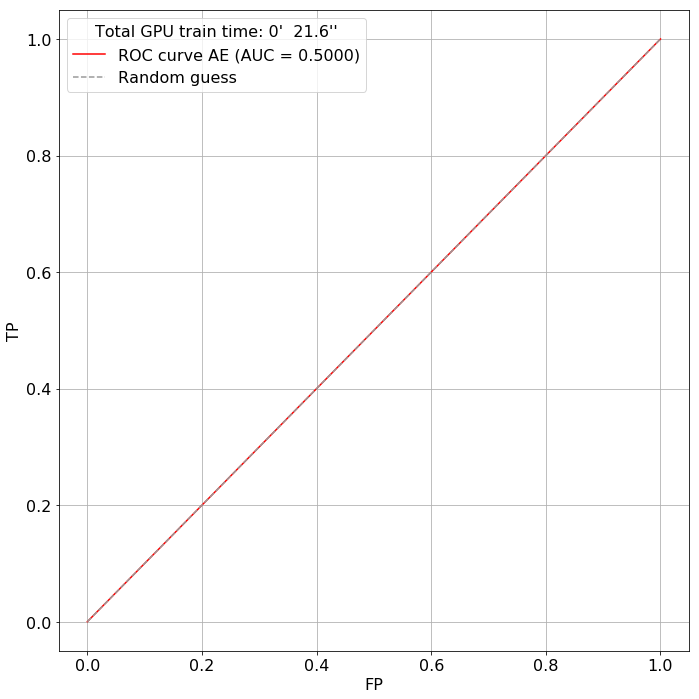

In [11]:
bkg = np.repeat(0, 50000)
sig = np.repeat(1, 25000)
true = np.concatenate((bkg,sig))
decoded_test = discriminator.predict(sample_test)
decoded_train = discriminator.predict(sample_train)
scores = np.concatenate((decoded_train,decoded_test))

print (decoded_test)

train_min = int(train_time) // 60
train_sec = train_time - 60 * train_min
time_stamp = "Total GPU train time: %d'  %.1f''" % (train_min, train_sec)

plt.figure(figsize=(10, 10))
                   
fp, vp, thresholds = roc_curve(true,scores[:,0])
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))

plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
plt.grid()
plt.legend(loc="best", prop={'size': 16}, title = time_stamp)
plt.tight_layout()
if savePlots:
    plt.savefig(plotsLocation + file_name + "ROC.png")

### Save Model


In [10]:
saveNetworks = True
updateWeights = True

if saveNetworks:
    discriminator_json = discriminator.to_json()
    with open("discriminator.json", "w") as json_file:
        json_file.write(discriminator_json)
    generator_json = generator.to_json()
    with open("generator.json", "w") as json_file:
        json_file.write(generator_json)

if updateWeights:
    discriminator.save_weights("discriminator.h5")
    generator.save_weights("generator.h5")
